In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

import tensorflow as tf
print(tf.__version__)  # Ensure that we're using "2.0.0-rc1"

2.0.0-rc1


In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from tensorflow.keras import Model


In [33]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [41]:
import sklearn.metrics as metrics

In [4]:
import pdb
from pdb import set_trace as bp

In [7]:
data = tf.keras.datasets.fashion_mnist

(x_train, y_train), (x_test, y_test) = data.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25,
                                                 shuffle=True)

# Add a channels dimension
x_train = x_train[..., tf.newaxis]
x_val = x_val[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

In [35]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


### Visualize images: 

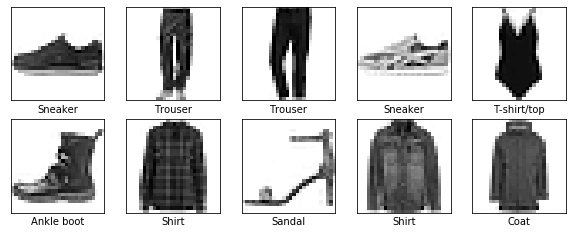

In [37]:
plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i][:,:,0], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i]])
plt.show()

In [8]:
x_train.shape

(45000, 28, 28, 1)

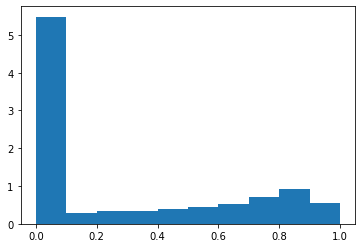

In [9]:
plt.hist(x_train[:, :, :, :].ravel(), density=True)
plt.show()

In [10]:
y_train.shape

(45000,)

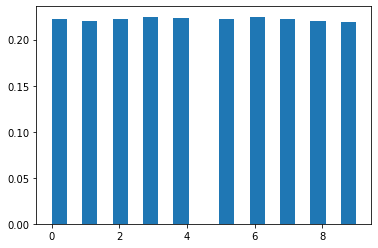

In [11]:
plt.hist(y_train,
         bins=20,
         density=True)
plt.show()

Batch and shuffle the data:


In [12]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(x_train.shape[0]).batch(32)
val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

In [107]:
class BasicConvNetModel(Model):
    def __init__(self, input_shape, number_of_conv_channels,
                 kernel_regularizer = None,
                 activity_regularizer = None,
                  kernel_size=3):
        super(BasicConvNetModel, self).__init__()
        self.number_of_conv_channels = number_of_conv_channels
        self.shape_in = input_shape
        self.conv1 = Conv2D(number_of_conv_channels, kernel_size,
                            activation='relu',
                            data_format='channels_last')
        
        self.max_pool = MaxPool2D(pool_size=(2, 2), strides=None,)
        self.flatten = Flatten()
        flat_shape = (input_shape[1] - kernel_size + 1) ** 2 / 2
        d1_flat_shape_output = int(flat_shape / 2)
        if kernel_regularizer or activity_regularizer:
            if activity_regularizer and kernel_regularizer:
                self.d1 = Dense(d1_flat_shape_output, activation='relu',
                               kernel_regularizer=kernel_regularizer,
                               activity_regularizer=activity_regularizer)
            else:
                if activity_regularizer:
                    self.d1 = Dense(d1_flat_shape_output, activation='relu',
                                   activity_regularizer=activity_regularizer)
                if kernel_regularizer:
                    self.d1 = Dense(d1_flat_shape_output, activation='relu',
                                   kernel_regularizer=kernel_regularizer)
        else:
            self.d1 = Dense(d1_flat_shape_output, activation='relu')
        self.d2 = Dense(10, activation='softmax')

    def call(self, x):
        # bp()
        x = self.conv1(x)
        x = self.max_pool(x)
        # bp()
        x = self.flatten(x)
        x = self.d1(x)
        x = self.d2(x)
        return x



In [14]:
# Create an instance of the model
with tf.device('gpu'):
    number_of_conv_channels = 10
    model = BasicConvNetModel(x_train.shape, number_of_conv_channels)
    images = tf.Variable(x_train[:32], dtype=float)
    print(images.shape)
    print(type(images))
    predictions = model(images)

(32, 28, 28, 1)
<class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'>


In [64]:
# @tf.function
def train_step(images, labels, 
               loss_object,
               model,
               optimizer, train_loss,
              train_accuracy):
    with tf.device('gpu'):
        with tf.GradientTape() as tape:
            predictions = model(images)
            loss = loss_object(labels, predictions)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        train_loss(loss)
        train_accuracy(labels, predictions)

In [65]:
# @tf.function
def val_step(images, labels, 
             loss_object, 
             model, val_loss, 
            val_accuracy):
    with tf.device('gpu'):
        predictions = model(images)
        t_loss = loss_object(labels, predictions)

        val_loss(t_loss)
        val_accuracy(labels, predictions)

In [105]:
def train_model(train_ds, 
                val_ds,
                parameters):
    """
        :param parameters: disctionary containing values for model
    """
    EPOCHS = parameters['EPOCHS']# 5
    # Create an instance of the model
    loss_object = parameters['loss_object']
    # tf.keras.losses.SparseCategoricalCrossentropy()

    optimizer = parameters['optimizer']# tf.keras.optimizers.Adam()
    train_loss = tf.keras.metrics.Mean(name='train_loss')
    train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
    
    val_loss = tf.keras.metrics.Mean(name='val_loss')
    val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy')
    with tf.device('gpu'):
        number_of_conv_channels = parameters['number_of_conv_channels'] # 10
        model = BasicConvNetModel(x_train.shape, number_of_conv_channels,
                                 kernel_regularizer=parameters['kernel_regularizer'],
                                 activity_regularizer=parameters['activity_regularizer'],
                                 kernel_size=parameters['kernel_size'])
        images = tf.Variable(x_train[:32], dtype=float)
        print(images.shape)
        print(type(images))
        predictions = model(images)
    for epoch in range(EPOCHS):
        # Reset the metrics for the next epoch
        train_loss.reset_states()
        train_accuracy.reset_states()
        val_loss.reset_states()
        val_accuracy.reset_states()
        for images, labels in train_ds:
            train_step(images, labels, loss_object, 
                      model, optimizer, train_loss, train_accuracy)

        for val_images, val_labels in val_ds:
            val_step(val_images, val_labels, loss_object, 
                    model, val_loss, val_accuracy)

        template = 'Epoch {}, Loss: {}, Accuracy: {}, val Loss: {}, val Accuracy: {}'
        print(template.format(epoch+1,
                            train_loss.result(),
                            train_accuracy.result()*100,
                            val_loss.result(),
                            val_accuracy.result()*100))

        
    return train_accuracy, val_accuracy, model

In [77]:
def test_model(model, test_ds):
    with tf.device('gpu'):
        probabilities = np.array([])
        predictions = np.array([])
        labels = np.array([])
        for test_images, test_labels in test_ds:
            # bp()

            result = model(test_images)
            labels = np.append(labels, test_labels)
            for item in result: 
                # predictions.append(tf.math.argmax(item))
                predictions = np.append(predictions, tf.math.argmax(item))
                probabilities = np.append(probabilities, item)
    return labels, predictions, probabilities

### Try to Find Better Model 
For a given set of parameters, try to find a better model. 

In [92]:
def find_best_model_for_params(parameter_container):
    train_accuracy_container = []
    val_accuracy_container = []
    model_container = []
    for parameters in parameter_container:
        # bp()
        train_accuracy, val_accuracy, model = train_model(train_ds, 
                                                  val_ds,
                                                  parameters)
        train_accuracy_container.append(train_accuracy.result().numpy())
        val_accuracy_container.append(val_accuracy.result().numpy())
        model_container.append(model)
    best_model_index = np.argmax(val_accuracy_container)
    return train_accuracy_container[best_model_index], val_accuracy_container[best_model_index], model_container[best_model_index], best_model_index

In [109]:
parameters_reg = {'EPOCHS': 3, 
                  'loss_object': tf.keras.losses.SparseCategoricalCrossentropy(),
                  'optimizer': tf.keras.optimizers.Adam(),
                  'number_of_conv_channels': 10,
                  'kernel_regularizer': None,
                  'activity_regularizer': None,
                  'kernel_size': 3}
parameters_l1 = {'EPOCHS': 3, 
                  'loss_object': tf.keras.losses.SparseCategoricalCrossentropy(),
                  'optimizer': tf.keras.optimizers.Adam(),
                  'number_of_conv_channels': 10,
                  'kernel_regularizer': tf.keras.regularizers.l1(l=0.01),
                  'activity_regularizer': None,
                  'kernel_size': 3}
parameters_l2 = {'EPOCHS': 3, 
                  'loss_object': tf.keras.losses.SparseCategoricalCrossentropy(),
                  'optimizer': tf.keras.optimizers.Adam(),
                  'number_of_conv_channels': 10,
                  'kernel_regularizer': tf.keras.regularizers.l2(l=0.01),
                  'activity_regularizer': None,
                  'kernel_size': 3}
parameter_container = [parameters_reg, 
                       parameters_l1, 
                       parameters_l2]
train_accuracy, val_accuracy, model, best_model_index = find_best_model_for_params(parameter_container)

(32, 28, 28, 1)
<class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'>

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1, Loss: 0.44789403676986694, Accuracy: 84.03556060791016, val Loss: 0.36190301179885864, val Accuracy: 86.6066665649414
Epoch 2, Loss: 0.30756646394729614, Accuracy: 88.81555938720703, val Loss: 0.28606826066970825, val Accuracy: 89.68000030517578
Epoch 3, Loss: 0.26265496015548706, Accuracy: 90.4044418334961, val Loss: 0.2726682722568512, val Accuracy: 90.22666931152344
(32, 28, 28, 1)
<class 'tensorflow.pytho

In [110]:
labels, predictions, probabilities = test_model(model, test_ds)

In [111]:
confusion_matrix = tf.math.confusion_matrix(labels, predictions)


In [112]:
report = metrics.classification_report(labels, predictions)
print(report)

              precision    recall  f1-score   support

         0.0       0.86      0.83      0.84      1000
         1.0       0.99      0.97      0.98      1000
         2.0       0.89      0.74      0.81      1000
         3.0       0.89      0.91      0.90      1000
         4.0       0.82      0.84      0.83      1000
         5.0       0.97      0.98      0.98      1000
         6.0       0.66      0.76      0.71      1000
         7.0       0.96      0.94      0.95      1000
         8.0       0.96      0.98      0.97      1000
         9.0       0.95      0.96      0.96      1000

   micro avg       0.89      0.89      0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



Text(69.0, 0.5, 'true labels')

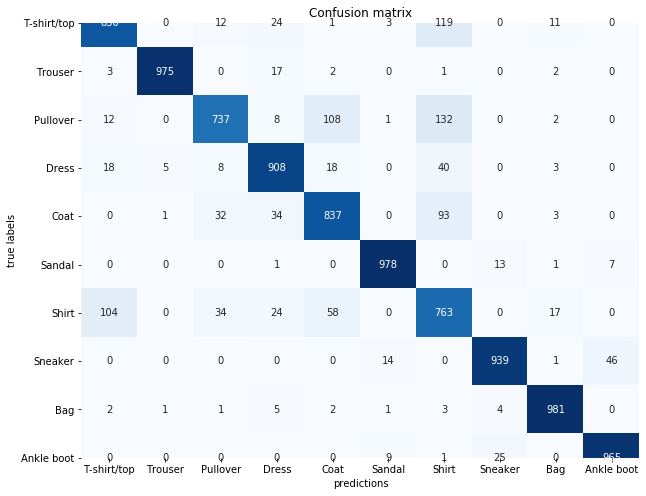

In [113]:
plt.figure(figsize=(10, 8))
plt.title("Confusion matrix")
sns.heatmap(confusion_matrix, cmap='Blues', 
            annot=True, 
            xticklabels=class_names, 
            yticklabels=class_names,
            fmt='g',
            cbar=False)
plt.xlabel('predictions')
plt.ylabel('true labels')

## Conclusions: 
It's possible to see that the chosen model performs fairly well. With the system implemented here, it's possible to change different parameters and do a sort of hyperparameter of optimization (somewhat manual, but it's possible). 

For the conditions given, the regular model performed best during validation. As a consequence it was chosen as the best model.